In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap lines
pd.set_option('display.expand_frame_repr', False)  # Don't break into multiple lines

In [2]:
load = ""
X_train = pd.read_csv(f'./datasets_after_transformation/eagle_data_all_completed_X_train.csv')
X_test= pd.read_csv(f'./datasets_after_transformation/eagle_data_all_completed_X_test.csv')
y_train = pd.read_csv(f'./datasets_after_transformation/eagle_data_all_completed_y_train.csv')
y_test = pd.read_csv(f'./datasets_after_transformation/eagle_data_all_completed_y_test.csv')

print(len(X_train), len(X_test), len(y_train), len(y_test))

18306 2937 18306 2937


In [3]:
# 1. Rename the target columns
y_train = y_train.rename(columns={"__y__": "run_time"})
y_test = y_test.rename(columns={"__y__": "run_time"})

# 2. Concatenate X and y for train and test
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# 3. Concatenate train and test into one dataframe
df_ = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)


## Feature Engineering

In [4]:
import numpy as np
import pandas as pd

# Parse submit_time as datetime first
df_['submit_time'] = pd.to_datetime(df_['submit_time'])

# Time-based features
df_['submit_hour_id'] = df_['submit_time'].dt.hour

df_['day_of_week_id'] = df_['submit_time'].dt.dayofweek.astype(int)

# # Time-of-day encoding
# df_['is_night_job'] = ((sh >= 22) | (sh < 6)).astype(int)
# df_['is_morning_job'] = ((sh >= 6) & (sh < 12)).astype(int)
# df_['is_afternoon_job'] = ((sh >= 12) & (sh < 18)).astype(int)
# df_['is_evening_job'] = ((sh >= 18) & (sh < 22)).astype(int)

# Weekend encoding
df_['is_weekend_id'] = df_['day_of_week_id'].isin([5, 6]).astype(int)

# # Concatenated categorical features
# df_["user_account"] = df_["user"] + "_" + df_["account"]
# df_["user_name"] = df_["user"] + "_" + df_["name"]
# df_["partition_qos"] = df_["partition"] + "_" + df_["qos"]
# df_["user_name_partition"] = df_["user"] + "_" + df_["name"] + "_" + df_["partition"]
# df_["name_partition"] = df_["name"] + "_" + df_["partition"]
# df_['user_qos'] = df_['user'] + '_' + df_['qos']
# df_['account_qos'] = df_['account'] + '_' + df_['qos']


# Job type classification
nodes = df_['nodes_req'].values
cpus = df_['processors_req'].values
gpus = df_['gpus_req'].values

conditions = [
    (gpus > 0) & (nodes > 1),
    (gpus > 0) & (nodes == 1),
    (gpus == 0) & (nodes > 1),
    (gpus == 0) & (nodes == 1) & (cpus > 1),
]
choices = ["distributed_gpu", "single_node_gpu", "distributed", "multithreaded"]

df_['job_type'] = np.select(conditions, choices, default="serial")
job_type_map = {"serial": 2, "multithreaded": 4, "distributed": 1, "single_node_gpu": 0, "distributed_gpu":3 }

df_['job_type_id'] = df_['job_type'].map(job_type_map).astype(int)

# Cold start flags
# df_['is_new_user'] = ~df_['user'].duplicated(keep='first').astype(int)
# df_['is_new_account'] = ~df_['account'].duplicated(keep='first').astype(int)
# df_['is_new_partition'] = ~df_['partition'].duplicated(keep='first').astype(int)
# df_['is_new_qos'] = ~df_['qos'].duplicated(keep='first').astype(int)
# df_['is_new_name'] = ~df_['name'].duplicated(keep='first').astype(int)

# Big data flag
BIG_DATA_THRESHOLD_MB = 102400 # 100GB
df_['is_big_data'] = (df_['mem_req'] >= BIG_DATA_THRESHOLD_MB).astype(int)

# Program type classification
def classify_program_type(row):
    jt = row['job_type_id']

    if row['gpus_req'] >= 1:
        return 0 if row['mem_req'] >= 16000 else 1 # DL else ML
    elif jt in [0, 1]:
        return 2 if row['processors_req'] >= 4 and row['mem_req'] >= 8000 else 3 # Simulation / MPI sinon cpu classique
    elif jt == 2 and not row['is_big_data']:
        return 4 # comlexity
    elif jt == 2 and row['is_big_data']: # data analysis
        return 5
    else:
        return 6

program_type = df_.apply(classify_program_type, axis=1)
df_['program_type_id'] = program_type.astype('category').cat.codes

df_['wallclock_job_type'] = df_['wallclock_req'].astype(str) + "|" + df_['job_type']

df_['program_type_job_type_wallclock']= df_['program_type_id'].astype(str)+'_'+df_['job_type'].astype(str) + df_['wallclock_req'].astype(str)

df_['partition_qos'] = df_['partition'].astype(str) + df_['qos'].astype(str)


df_['program_type_job_type_qos_partition'] = (
    df_['program_type_id'].astype(str) + '_' +
    df_['job_type'].astype(str) + '_' +
    df_['qos'].astype(str) + '_' +
    df_['partition'].astype(str))

# Convert submit_time and end_time to UNIX timestamps
if not np.issubdtype(df_['submit_time'].dtype, np.integer):
    df_['submit_time'] = pd.to_datetime(df_['submit_time']).astype('int64') // 10**9
    df_['end_time'] = pd.to_datetime(df_['end_time']).astype('int64') // 10**9

# Now ready for target encoding or modeling steps

In [ ]:
# Identify categorical and numerical features

# Categorical: All *_id columns and other known categorical features
categorical_features = [
] + ['program_type_job_type_qos_partition','program_type_job_type_wallclock','partition_qos','job_type_id','program_type_id']


# Numerical: All columns not in categorical and not the target
exclude_cols = set(categorical_features + ['run_time', 'submit_time', 'end_time'])
numerical_features = [col for col in df_.columns if col not in exclude_cols and df_[col].dtype != 'object']
print("Categorical:", categorical_features)
print("Numerical:", numerical_features)


Categorical: ['program_type_job_type_qos_partition', 'program_type_job_type_wallclock', 'partition_qos', 'job_type_id', 'program_type_id']
Numerical: ['job_id', 'partition', 'qos', 'wallclock_req', 'nodes_req', 'processors_req', 'gpus_req', 'mem_req', 'user_account_name', 'processors_req_nodes', 'processors_req_mem', 'nodes_req_mem', 'partition_wallclock', 'submit_hour_id', 'day_of_week_id', 'is_weekend_id', 'is_big_data']


In [6]:
from sklearn.preprocessing import LabelEncoder

for col in categorical_features:
    encoder = LabelEncoder()
    df_[col] = encoder.fit_transform(df_[col])

In [7]:
id_columns = categorical_features

features_te = id_columns

features_overestimation = id_columns

features_min_max_avg = id_columns
# ema = te but with alpha control on which to take more
features_ema_runtime = id_columns


df_columns = set(df_.columns.astype(str))

# Filter each feature list to keep only those present in df_
features_te = [f for f in features_te if f in df_columns]
features_overestimation = [f for f in features_overestimation if f in df_columns]
features_min_max_avg = [f for f in features_min_max_avg if f in df_columns]
features_ema_runtime = [f for f in features_ema_runtime if f in df_columns]

## Last 5 Run Time seen

In [8]:
import numpy as np
import bisect

def compute_lastk_features_with_fallback(df_, category_col, group_col, run_time_col, submit_time_col, end_time_col, k):
    n = len(df_)
    features = np.zeros((n, k), dtype=np.float32)

    # Extract numpy arrays
    categories = df_[category_col].values
    groups = df_[group_col].values
    run_times = df_[run_time_col].values
    submit_times = df_[submit_time_col].values
    end_times = df_[end_time_col].values

    # Sort by end_time
    sorted_idx = np.argsort(end_times)

    history = {}         # category -> {'end_times': [], 'run_times': []}
    backup_history = {}  # group     -> {'end_times': [], 'run_times': []}

    for idx in sorted_idx:
        cat = categories[idx]
        grp = groups[idx]
        t_submit = submit_times[idx]
        y = run_times[idx]

        if cat not in history:
            history[cat] = {'end_times': [], 'run_times': []}
        if grp not in backup_history:
            backup_history[grp] = {'end_times': [], 'run_times': []}

        # Job-specific history
        hist_et = history[cat]['end_times']
        hist_rt = history[cat]['run_times']

        # Fallback group history
        grp_et = backup_history[grp]['end_times']
        grp_rt = backup_history[grp]['run_times']

        # Binary search: job-level
        pos = bisect.bisect_left(hist_et, t_submit)
        lastk = hist_rt[max(0, pos - k):pos]

        # Padding
        padded = np.zeros(k, dtype=np.float32)
        if len(lastk) > 0:
            padded[-len(lastk):] = lastk
        else:
            # Fallback to group-level if all zero
            gpos = bisect.bisect_left(grp_et, t_submit)
            fallback = grp_rt[max(0, gpos - k):gpos]
            if len(fallback) > 0:
                padded[-len(fallback):] = fallback

        features[idx, :] = padded

        # Update both histories
        hist_et.append(end_times[idx])
        hist_rt.append(y)
        grp_et.append(end_times[idx])
        grp_rt.append(y)

    # Assign back to DataFrame
    for i in range(k):
        df_[f'last_run_time_{i+1}'] = features[:, i]

    return df_
df_ = compute_lastk_features_with_fallback(
    df_,
    category_col='program_type_job_type_wallclock',
    group_col='partition_qos',  
    run_time_col='run_time',
    submit_time_col='submit_time',
    end_time_col='end_time',
    k=5
)

## Cumulative target encoding

In [9]:
import numpy as np
import bisect

def compute_cumulative_te_on_df(df_, category_cols, target_col, submit_time_col, end_time_col, threshold=1000, penalty_weight=0.1):
    n_features = len(category_cols)
    n_samples = len(df_)

    avg_mat = np.zeros((n_samples, n_features), dtype=np.float64)

    # Extract numpy arrays for faster access
    submit_times = df_[submit_time_col].values
    end_times = df_[end_time_col].values
    targets = df_[target_col].values

    category_arrays = [df_[col].values.astype(int) for col in category_cols]

    sorted_idx = np.argsort(end_times)

    # Initialize history for each feature and category
    hist_times_all = []
    hist_vals_all = []
    ptrs_all = []
    sum_all = []
    count_all = []

    for f, cat_col in enumerate(category_cols):
        max_id = int(df_[cat_col].max()) + 1
        hist_times_all.append([[] for _ in range(max_id)])
        hist_vals_all.append([[] for _ in range(max_id)])
        ptrs_all.append(np.zeros(max_id, dtype=int))
        sum_all.append(np.zeros(max_id, dtype=np.float64))
        count_all.append(np.zeros(max_id, dtype=np.float64))

    for i in sorted_idx:
        t_sub = submit_times[i]
        t_end = end_times[i]
        y = targets[i]

        for f in range(n_features):
            cat_id = category_arrays[f][i]

            times = hist_times_all[f][cat_id]
            vals = hist_vals_all[f][cat_id]

            # Use bisect for efficient pointer movement
            ptr = ptrs_all[f][cat_id]
            # Find the index where times[j] >= t_sub
            j = bisect.bisect_left(times, t_sub, ptr)

            # Update cumulative sums/counts with new entries
            for idx_j in range(ptr, j):
                y_j = vals[idx_j]
                weight = penalty_weight if y_j > threshold else 1.0
                sum_all[f][cat_id] += y_j * weight
                count_all[f][cat_id] += weight

            ptrs_all[f][cat_id] = j

            # Compute average encoding
            cum_count = count_all[f][cat_id]
            cum_sum = sum_all[f][cat_id]
            avg_mat[i, f] = cum_sum / cum_count if cum_count > 0 else 0.0

            # Append current record (t_end, y)
            # Insert in sorted order to keep times sorted - but we always append because
            # we process in ascending end_time order
            times.append(t_end)
            vals.append(y)

    # Add new columns to df_
    for f, cat_col in enumerate(category_cols):
        new_col_name = f'cum_te_{cat_col}'
        df_[new_col_name] = avg_mat[:, f]

    return df_


df_ = compute_cumulative_te_on_df(
    df_,
    category_cols=features_te,
    target_col='run_time',
    submit_time_col='submit_time',
    end_time_col='end_time',
    threshold=90000000, penalty_weight=0.5)

# Cumulative statistics ( min / max/ avg )

In [10]:
import numpy as np
import numba
from numba.typed import List

@numba.njit
def compute_min_max_avg_unified(
    submit_ts, end_ts, run_times, group_ids, 
    threshold=800.0, penalty_weight=0.01
):
    n_samples = len(run_times)
    sorted_idx = np.argsort(end_ts)
    reverse_idx = np.empty_like(sorted_idx)
    for i in range(n_samples):
        reverse_idx[sorted_idx[i]] = i

    submit_ts = submit_ts[sorted_idx]
    end_ts = end_ts[sorted_idx]
    run_times = run_times[sorted_idx]
    group_ids = group_ids[sorted_idx]

    max_gid = np.max(group_ids) + 1

    seen_min = np.zeros(n_samples, dtype=np.float32)
    seen_max = np.zeros(n_samples, dtype=np.float32)
    seen_avg = np.zeros(n_samples, dtype=np.float32)

    hist_end = List()
    hist_val = List()
    for _ in range(max_gid):
        hist_end.append(List.empty_list(numba.types.int64))
        hist_val.append(List.empty_list(numba.types.float32))

    last_min = np.full(max_gid, np.inf, dtype=np.float32)
    last_max = np.full(max_gid, -np.inf, dtype=np.float32)
    last_sum = np.zeros(max_gid, dtype=np.float32)
    last_count = np.zeros(max_gid, dtype=np.int32)
    last_ptr = np.zeros(max_gid, dtype=np.int32)

    for i in range(n_samples):
        g = group_ids[i]
        t_sub = submit_ts[i]
        t_end = end_ts[i]
        rt = run_times[i]

        ends = hist_end[g]
        vals = hist_val[g]
        ptr = last_ptr[g]

        while ptr < len(ends) and ends[ptr] < t_sub:
            v = vals[ptr]

            if v < last_min[g]:
                last_min[g] = v
            if v > last_max[g]:
                last_max[g] = v

            weight = penalty_weight if v > threshold else 1.0
            last_sum[g] += v * weight
            last_count[g] += 1
            ptr += 1

        last_ptr[g] = ptr

        if last_count[g] > 0:
            seen_min[i] = last_min[g]
            seen_max[i] = last_max[g]
            seen_avg[i] = last_sum[g] / last_count[g]
        else:
            seen_min[i] = 0.0
            seen_max[i] = 0.0
            seen_avg[i] = 0.0

        ends.append(np.int64(t_end))
        vals.append(np.float32(rt))

    return seen_min[reverse_idx], seen_max[reverse_idx], seen_avg[reverse_idx]
from joblib import Parallel, delayed

# Set values
threshold = 90000000
penalty_weight = 0.3

run_times = df_['run_time']
submit_ts = df_['submit_time']
end_ts = df_['end_time']

# Run parallel
results = Parallel(n_jobs=-1)(
    delayed(lambda col: (
        col,
        *compute_min_max_avg_unified(
            submit_ts.values,
            end_ts.values,
            run_times.values,
            df_[col].to_numpy(dtype=np.int32),
            threshold=threshold,
            penalty_weight=penalty_weight
        )
    ))(col)
    for col in features_min_max_avg
)

# Assign results back to DataFrame
for col_name, min_feat, max_feat, avg_feat in results:
    df_[f"{col_name}_min_runtime_seen"] = min_feat
    df_[f"{col_name}_max_runtime_seen"] = max_feat
    df_[f"{col_name}_avg_runtime_seen"] = avg_feat

## Correct the wallclock

In [11]:
import numpy as np

def compute_ema_unified(submit_ts, end_ts, values, features_int, alpha_high=1, alpha_low=0.01):
    n_features, n_samples = features_int.shape
    ema_mat = np.zeros((n_features, n_samples), dtype=np.float32)

    # Sort to ensure causality
    sorted_idx = np.argsort(end_ts)
    submit_ts = submit_ts[sorted_idx]
    end_ts = end_ts[sorted_idx]
    values = values[sorted_idx]
    features_int = features_int[:, sorted_idx]

    last_times_all = []
    last_vals_all = []
    last_ptrs_all = []
    last_ema_all = []

    for f in range(n_features):
        max_id = int(np.max(features_int[f])) + 1
        last_times_all.append([[] for _ in range(max_id)])
        last_vals_all.append([[] for _ in range(max_id)])
        last_ptrs_all.append([0] * max_id)
        last_ema_all.append([0.0] * max_id)

    for i in range(n_samples):
        for f in range(n_features):
            cat_id = features_int[f, i]
            t_sub = submit_ts[i]
            t_end = end_ts[i]
            val = values[i]

            times = last_times_all[f][cat_id]
            vals = last_vals_all[f][cat_id]
            ptr = last_ptrs_all[f][cat_id]
            ema = last_ema_all[f][cat_id]


            j = ptr
            while j < len(times) and times[j] < t_sub:
                past_val = vals[j]
                # Also use alpha depending on past_val (optional)
                alpha_j = alpha_low if past_val > 90000000 else alpha_high
                ema = alpha_j * past_val + (1 - alpha_j) * ema
                j += 1

            last_ptrs_all[f][cat_id] = j
            last_ema_all[f][cat_id] = ema
            ema_mat[f, sorted_idx[i]] = ema

            times.append(t_end)
            vals.append(val)

    return ema_mat


# Last Run_time/Wallclock ratio


In [12]:
def compute_runtime_wallclock_ratio(runtime, wallclock):
    safe_wallclock = np.where(wallclock > 0, wallclock, 1e-6)
    return (runtime / safe_wallclock) # pourcentage d'utilisation du wallclock

# Compute runtime-to-wallclock ratio
df_["ratio_runtime"] = compute_runtime_wallclock_ratio(df_["run_time"], df_["wallclock_req"])

features_ratio = features_overestimation # adjust as needed

# Integer matrix (n_features, n_samples)
features_int = np.stack([df_[col].to_numpy(np.int32) for col in features_ratio])

# Compute EMA matrix
ema_ratio_mat = compute_ema_unified(
    df_["submit_time"].to_numpy(np.int64),
    df_["end_time"].to_numpy(np.int64),
    df_["ratio_runtime"].to_numpy(np.float32),
    features_int,
    alpha_low=0.4, 
    alpha_high=1
)

for i, col in enumerate(features_ratio):
    df_[f"{col}_ratio_runtime_ema"] = ema_ratio_mat[i] * df_['wallclock_req']

df_.drop(columns='ratio_runtime', inplace=True)

## Follow runtime behavior

In [13]:
features_int = np.stack([df_[col].to_numpy(np.int32) for col in features_ema_runtime])
ema_runtime_mat = compute_ema_unified(
    submit_ts=df_["submit_time"].to_numpy(np.int64),
    end_ts=df_["end_time"].to_numpy(np.int64),
    values=df_["run_time"].to_numpy(np.float32),
    features_int=features_int,
    alpha_low=0.1, 
    alpha_high=1
)
for i, col in enumerate(features_ema_runtime):
    df_[f"{col}_runtime_ema"] = ema_runtime_mat[i]

In [14]:
df_['processors_req_nodes'] = df_['processors_req']/ df_['nodes_req']
df_['processors_req_mem'] = df_['mem_req']/ df_['processors_req']
df_['nodes_req_mem'] =  df_['mem_req']/df_['nodes_req']
df_['partition_wallclock'] = df_['partition'] * df_['wallclock_req']


df_.drop(columns=['end_time'], inplace=True)

In [15]:
n_train = len(X_train)
n_test = len(X_test)

# 2. Recreate X and y from df_
X_all = df_.drop(columns=['run_time'])
y_all = df_['run_time']

# 3. Resplit exactly as before
X_train = X_all.iloc[:n_train].copy()
X_test = X_all.iloc[n_train:].copy()

y_train = y_all.iloc[:n_train].copy()
y_test = y_all.iloc[n_train:].copy()

## Correlation

Features with correlation |r| > 0.4 with run_time:
partition_wallclock                                     0.675118
program_type_job_type_wallclock_max_runtime_seen        0.663617
wallclock_req                                           0.654592
program_type_id_ratio_runtime_ema                       0.636774
cum_te_program_type_job_type_qos_partition              0.631849
program_type_job_type_qos_partition_avg_runtime_seen    0.631848
job_type_id_ratio_runtime_ema                           0.629848
cum_te_partition_qos                                    0.627616
partition_qos_avg_runtime_seen                          0.627616
partition_qos_ratio_runtime_ema                         0.621409
cum_te_program_type_job_type_wallclock                  0.610817
program_type_job_type_wallclock_avg_runtime_seen        0.610817
partition_qos_runtime_ema                               0.567414
partition_qos                                           0.549077
partition                              

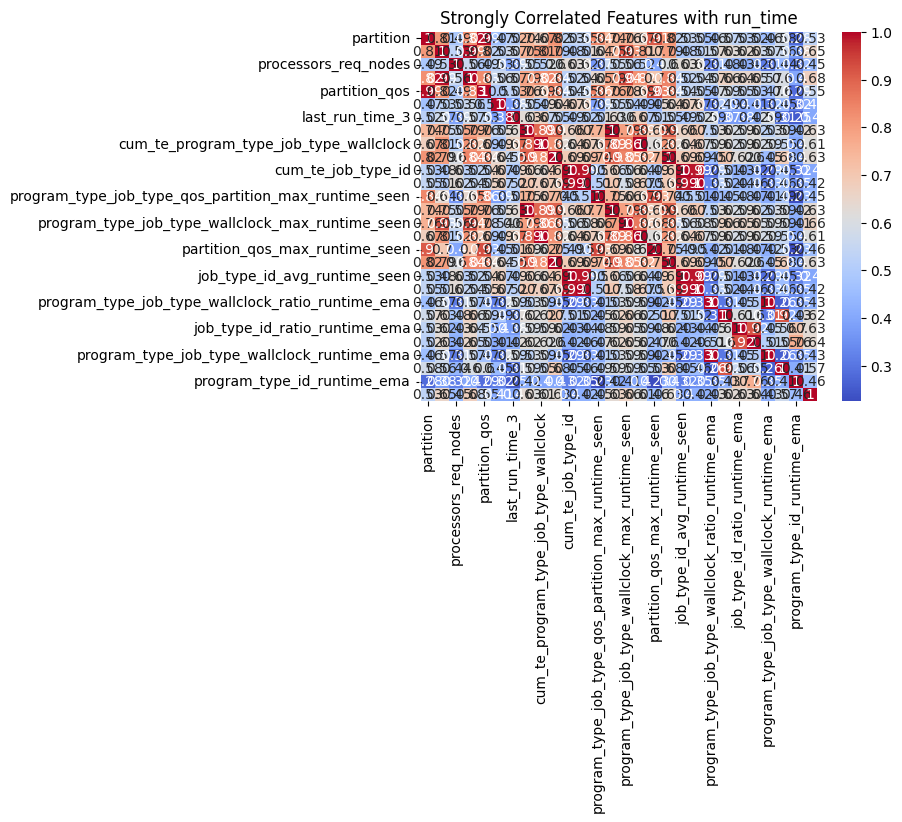

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select only numeric features from X_train
X_numeric = X_train.select_dtypes(include='number').copy()

# Step 2: Add y_train as a new column
X_numeric['run_time'] = y_train.values

# Step 3: Compute correlation matrix
corr_matrix = X_numeric.corr()

# Step 4: Extract correlation with run_time
run_time_corr = corr_matrix['run_time'].drop('run_time')

# Step 5: Filter features with absolute correlation > 0.4
strong_corr = run_time_corr[run_time_corr.abs() > 0.4]
strong_corr_features = strong_corr.index.tolist()

# Step 6: Subset X_train with those features
X_train_strong = X_train[strong_corr_features]

# Optional: Display results
print("Features with correlation |r| > 0.4 with run_time:")
print(strong_corr.sort_values(ascending=False))

# Optional: Show correlation heatmap
sns.heatmap(corr_matrix.loc[strong_corr_features + ['run_time'], strong_corr_features + ['run_time']],
            annot=True, cmap='coolwarm')
plt.title("Strongly Correlated Features with run_time")
plt.show()


In [17]:
import os

# Define the directory name
directory_name = "datasets_after_transformation"

# Check if the directory exists, if not, create it
if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    print(f"Directory '{directory_name}' created.")
else:
    print(f"Directory '{directory_name}' already exists.")

Directory 'datasets_after_transformation' already exists.


In [18]:
X_train.select_dtypes(include='number').columns

Index(['job_id', 'partition', 'qos', 'wallclock_req', 'nodes_req',
       'processors_req', 'gpus_req', 'mem_req', 'submit_time',
       'user_account_name', 'job_type_id', 'processors_req_nodes',
       'processors_req_mem', 'nodes_req_mem', 'partition_wallclock',
       'submit_hour_id', 'day_of_week_id', 'is_weekend_id', 'is_big_data',
       'program_type_id', 'program_type_job_type_wallclock', 'partition_qos',
       'program_type_job_type_qos_partition', 'last_run_time_1',
       'last_run_time_2', 'last_run_time_3', 'last_run_time_4',
       'last_run_time_5', 'cum_te_program_type_job_type_qos_partition',
       'cum_te_program_type_job_type_wallclock', 'cum_te_partition_qos',
       'cum_te_job_type_id', 'cum_te_program_type_id',
       'program_type_job_type_qos_partition_min_runtime_seen',
       'program_type_job_type_qos_partition_max_runtime_seen',
       'program_type_job_type_qos_partition_avg_runtime_seen',
       'program_type_job_type_wallclock_min_runtime_seen',
    

In [ ]:
drop = []

X_test = X_test.drop(columns=drop, errors='ignore')
X_train = X_train.drop(columns=drop, errors='ignore')

In [20]:

X_train.to_csv('datasets_after_transformation/eagle_data_all_completed_X_train.csv', index=False)
X_test.to_csv('datasets_after_transformation/eagle_data_all_completed_X_test.csv', index=False)
y_train.to_csv('datasets_after_transformation/eagle_data_all_completed_y_train.csv', index=False)
y_test.to_csv('datasets_after_transformation/eagle_data_all_completed_y_test.csv', index=False)